## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.regularizers import l2

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.25, l2_ratio=0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
            
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [256, 512, 1024]
DROPOUT = 0.25
L2_ratio = [1e-6, 1e-12]
MOMENTUM = 0.95

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batch_sz in BATCH_SIZE:
    for l2r in L2_ratio:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with batch size: %d and l2 ratio: %.12f" % (batch_sz, l2r))
        model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=DROPOUT, l2_ratio=l2r)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train,
                  epochs=EPOCHS, 
                  batch_size=batch_sz,
                  validation_data=(x_test, y_test),
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        exp_name_tag = "exp-Batch size %s-l2 %s" % (str(batch_sz), str(l2r))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

W0725 19:26:36.111461   732 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0725 19:26:36.111461   732 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0725 19:26:36.125291   732 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 19:26:36.129286   732 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 19:26:36.129286   

Experiment with batch size: 256 and l2 ratio: 0.000001000000


W0725 19:26:36.330836   732 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 19:26:36.414229   732 deprecation.py:323] From D:\Anaconda3\envs\keras37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

50000/50000 [==============================] - 2s 40us/step - loss: 1.2755 - acc: 0.5459 - val_loss: 1.3384 - val_acc: 0.5248
Epoch 48/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2745 - acc: 0.5439 - val_loss: 1.3212 - val_acc: 0.5306
Epoch 49/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2603 - acc: 0.5501 - val_loss: 1.3679 - val_acc: 0.5164
Epoch 50/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2602 - acc: 0.5481 - val_loss: 1.3256 - val_acc: 0.5327
Experiment with batch size: 256 and l2 ratio: 0.000000000001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
bat

Epoch 43/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2914 - acc: 0.5407 - val_loss: 1.3583 - val_acc: 0.5089
Epoch 44/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2962 - acc: 0.5336 - val_loss: 1.3546 - val_acc: 0.5127
Epoch 45/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2823 - acc: 0.5407 - val_loss: 1.3657 - val_acc: 0.5052
Epoch 46/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2875 - acc: 0.5376 - val_loss: 1.3496 - val_acc: 0.5202
Epoch 47/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2913 - acc: 0.5362 - val_loss: 1.3538 - val_acc: 0.5130
Epoch 48/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2781 - acc: 0.5415 - val_loss: 1.3493 - val_acc: 0.5166
Epoch 49/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2687 - acc: 0.5440 - val_loss: 1.3691 - val_acc: 0.5034
Epoch 50/50
50000/50000 [=========

50000/50000 [==============================] - 2s 30us/step - loss: 1.3256 - acc: 0.5247 - val_loss: 1.3492 - val_acc: 0.5139
Epoch 39/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.3219 - acc: 0.5253 - val_loss: 1.3647 - val_acc: 0.5090
Epoch 40/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.3178 - acc: 0.5256 - val_loss: 1.3342 - val_acc: 0.5189
Epoch 41/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.3051 - acc: 0.5321 - val_loss: 1.3290 - val_acc: 0.5234
Epoch 42/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.3015 - acc: 0.5314 - val_loss: 1.3477 - val_acc: 0.5084
Epoch 43/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.3018 - acc: 0.5342 - val_loss: 1.3442 - val_acc: 0.5178
Epoch 44/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.2908 - acc: 0.5371 - val_loss: 1.3358 - val_acc: 0.5244
Epoch 45/50
50000/50000 [=====================

Epoch 34/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.3445 - acc: 0.5176 - val_loss: 1.3455 - val_acc: 0.5204
Epoch 35/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.3399 - acc: 0.5203 - val_loss: 1.3618 - val_acc: 0.5154
Epoch 36/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.3290 - acc: 0.5270 - val_loss: 1.3425 - val_acc: 0.5161
Epoch 37/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.3234 - acc: 0.5233 - val_loss: 1.3490 - val_acc: 0.5162
Epoch 38/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.3186 - acc: 0.5273 - val_loss: 1.3586 - val_acc: 0.5105
Epoch 39/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.3096 - acc: 0.5294 - val_loss: 1.3395 - val_acc: 0.5229
Epoch 40/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.3065 - acc: 0.5292 - val_loss: 1.3341 - val_acc: 0.5207
Epoch 41/50
50000/50000 [=========

50000/50000 [==============================] - 1s 26us/step - loss: 1.4731 - acc: 0.4725 - val_loss: 1.4087 - val_acc: 0.4979
Epoch 30/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.4650 - acc: 0.4778 - val_loss: 1.4104 - val_acc: 0.4974
Epoch 31/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.4561 - acc: 0.4809 - val_loss: 1.4076 - val_acc: 0.4984
Epoch 32/50
50000/50000 [==============================] - 1s 27us/step - loss: 1.4540 - acc: 0.4823 - val_loss: 1.4074 - val_acc: 0.4981
Epoch 33/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.4457 - acc: 0.4828 - val_loss: 1.3956 - val_acc: 0.5051
Epoch 34/50
50000/50000 [==============================] - 1s 27us/step - loss: 1.4362 - acc: 0.4871 - val_loss: 1.3956 - val_acc: 0.5046
Epoch 35/50
50000/50000 [==============================] - 1s 27us/step - loss: 1.4321 - acc: 0.4887 - val_loss: 1.3946 - val_acc: 0.5060
Epoch 36/50
50000/50000 [=====================

Epoch 25/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.5015 - acc: 0.4668 - val_loss: 1.4258 - val_acc: 0.4922
Epoch 26/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.4942 - acc: 0.4705 - val_loss: 1.4360 - val_acc: 0.4863
Epoch 27/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.4833 - acc: 0.4725 - val_loss: 1.4240 - val_acc: 0.4915
Epoch 28/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.4775 - acc: 0.4757 - val_loss: 1.4351 - val_acc: 0.4856
Epoch 29/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.4712 - acc: 0.4746 - val_loss: 1.4136 - val_acc: 0.4963
Epoch 30/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.4651 - acc: 0.4757 - val_loss: 1.4262 - val_acc: 0.4872
Epoch 31/50
50000/50000 [==============================] - 1s 26us/step - loss: 1.4551 - acc: 0.4816 - val_loss: 1.4068 - val_acc: 0.4947
Epoch 32/50
50000/50000 [=========

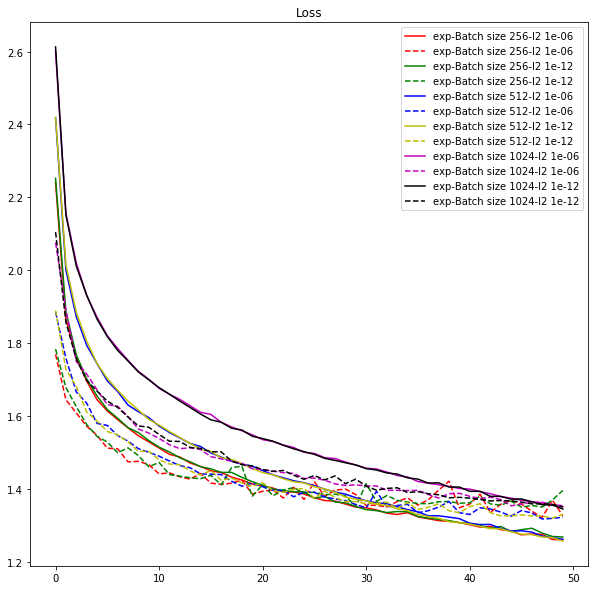

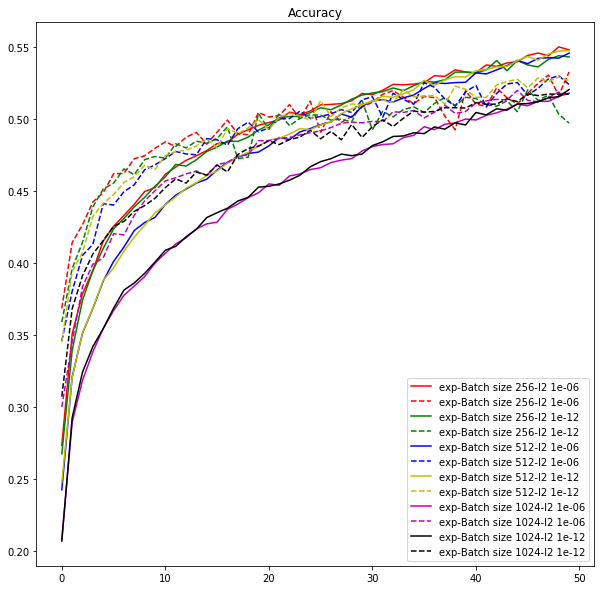

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]
             
plt.figure(figsize=(10,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], "--", label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]["train-acc"])), results[cond]["train-acc"], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]["valid-acc"])), results[cond]["valid-acc"], "--", label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()